In [48]:
import codecs
import numpy as np
import pandas as pd
import re

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import * 
from nltk.stem.snowball import SnowballStemmer 
from nltk.stem import WordNetLemmatizer


from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm, datasets, tree
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('C:\\SMSSpamCollection.csv',  sep='\t', names=["label", "message"])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.groupby('label').describe()

message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4

Отсюда видно, что ham намного более частотный, чем spam. Значит выборка не сбалансирована и с этим надо что-то делать.

In [34]:
#data1 = df[["label", "message"]] 
spam = df[df['label'] == 'spam']
ham = df[df['label'] == 'ham']

spam_data = []
ham_data = []

for i in spam.stack().value_counts(): 
    spam_data.append(i)
for i in ham.stack().value_counts():
    ham_data.append(i)

In [39]:
train_set = pd.concat([spam[:300], ham[:300]], ignore_index = True)
test_set = pd.concat([spam[400:500], ham[400:500]], ignore_index = True)

x_train = list(train_set['message'])
y_train = np.array(train_set['label'])
x_test = list(test_set['message'])
y_test = np.array(test_set['label'])

train_set.groupby('label').describe()

message
label                                                          
ham   count                                                 300
      unique                                                294
      top                                Sorry, I'll call later
      freq                                                    3
spam  count                                                 300
      unique                                                286
      top     Congratulations ur awarded 500 of CD vouchers ...
      freq                                                    2

In [40]:
def plot_confusion_matrix(cm, classes, #Функция из документации sklearn
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    


Count Vectorizer
             precision    recall  f1-score   support

        ham       0.47      0.54      0.50       100
       spam       0.45      0.38      0.41       100

avg / total       0.46      0.46      0.46       200

Confusion matrix, without normalization
[[54 46]
 [62 38]]
Tf-idf
             precision    recall  f1-score   support

        ham       0.48      0.50      0.49       100
       spam       0.48      0.46      0.47       100

avg / total       0.48      0.48      0.48       200

Confusion matrix, without normalization
[[50 50]
 [54 46]]


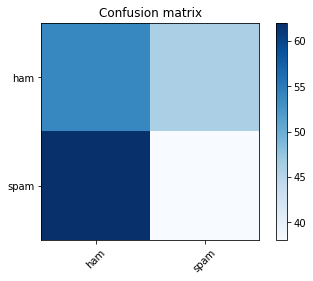

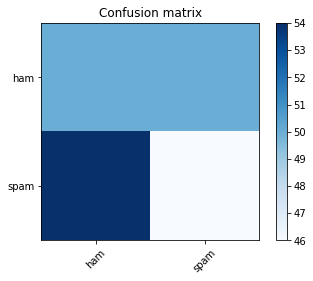

In [42]:
def tokenize(text):
    text = text.lower()
    return word_tokenize(text)

def tokenize_wo_punkt(text): #Токенизация без пунктуации
    return word_tokenize(re.sub("[.,!?\(\)\-\:\;\'\"]", "", text.lower()))

def nb_classif(bow): # Бейслайн
    nb_model = DummyClassifier()  # <----
    b_train = bow.fit_transform(x_train) 
    nb_model.fit(b_train, y_train)
    b_test = bow.transform(x_test)
    predict = nb_model.predict(b_test)
    matrix = confusion_matrix(y_test, predict)
#    print("\n", vect_type, m_type)
    print(classification_report(y_test, predict, target_names=['ham', 'spam']))
    plt.figure()
#    print("\n", vect_type, m_type)
    plot_confusion_matrix(matrix, classes=['ham', 'spam'])
    
bow = CountVectorizer(analyzer=tokenize_wo_punkt)
print ('Count Vectorizer')
nb_classif(bow)
bow = TfidfVectorizer(analyzer=tokenize_wo_punkt)
print('Tf-idf')
nb_classif(bow)

Count Vectorizer
             precision    recall  f1-score   support

        ham       0.92      0.92      0.92       100
       spam       0.92      0.92      0.92       100

avg / total       0.92      0.92      0.92       200

Confusion matrix, without normalization
[[92  8]
 [ 8 92]]
Tf-idf
             precision    recall  f1-score   support

        ham       0.93      0.93      0.93       100
       spam       0.93      0.93      0.93       100

avg / total       0.93      0.93      0.93       200

Confusion matrix, without normalization
[[93  7]
 [ 7 93]]


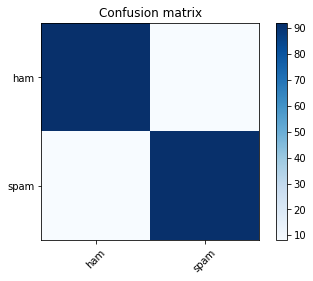

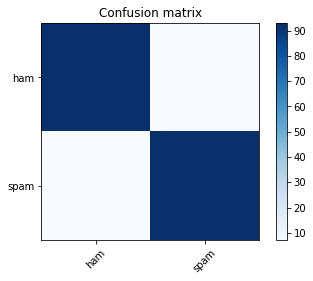

In [44]:
def tokenize(text):
    text = text.lower()
    return word_tokenize(text)

def tokenize_wo_punkt(text): # Токенизация без пунктуации
    return word_tokenize(re.sub("[.,!?\(\)\-\:\;\'\"]", "", text.lower()))

def nb_classif(bow): # Наивный Байес
    nb_model = MultinomialNB()  # <----
    b_train = bow.fit_transform(x_train) 
    nb_model.fit(b_train, y_train)
    b_test = bow.transform(x_test)
    predict = nb_model.predict(b_test)
    matrix = confusion_matrix(y_test, predict)
#    print("\n", vect_type, m_type)
    print(classification_report(y_test, predict, target_names=['ham', 'spam']))
    plt.figure()
#    print("\n", vect_type, m_type)
    plot_confusion_matrix(matrix, classes=['ham', 'spam'])
    
bow = CountVectorizer(analyzer=tokenize_wo_punkt)
print ('Count Vectorizer')
nb_classif(bow)
bow = TfidfVectorizer(analyzer=tokenize_wo_punkt)
print('Tf-idf')
nb_classif(bow)

Count Vectorizer
             precision    recall  f1-score   support

        ham       0.95      0.96      0.96       100
       spam       0.96      0.95      0.95       100

avg / total       0.96      0.95      0.95       200

Confusion matrix, without normalization
[[96  4]
 [ 5 95]]
Tf-idf
             precision    recall  f1-score   support

        ham       0.94      0.95      0.95       100
       spam       0.95      0.94      0.94       100

avg / total       0.95      0.94      0.94       200

Confusion matrix, without normalization
[[95  5]
 [ 6 94]]


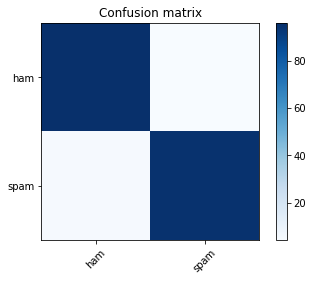

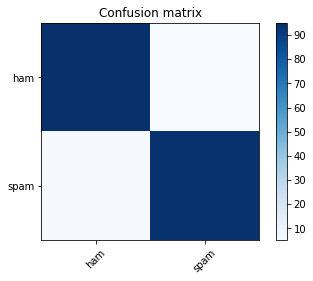

In [46]:
def tokenize_w_punkt(text): # Токенизация с пунктуацией
    return wordpunct_tokenize(text.lower()) 

bow = CountVectorizer(analyzer=tokenize_w_punkt)
print ('Count Vectorizer')
nb_classif(bow)
bow = TfidfVectorizer(analyzer=tokenize_w_punkt)
print('Tf-idf')
nb_classif(bow)

Count Vectorizer
             precision    recall  f1-score   support

        ham       0.83      0.98      0.90       100
       spam       0.98      0.80      0.88       100

avg / total       0.90      0.89      0.89       200

Confusion matrix, without normalization
[[98  2]
 [20 80]]
Tf-idf
             precision    recall  f1-score   support

        ham       0.84      0.98      0.91       100
       spam       0.98      0.82      0.89       100

avg / total       0.91      0.90      0.90       200

Confusion matrix, without normalization
[[98  2]
 [18 82]]


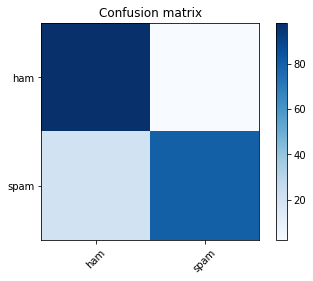

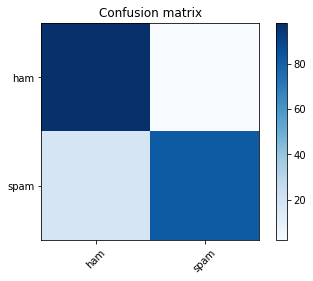

In [49]:
def tokenize(text):
    text = text.lower()
    return word_tokenize(text)

def tokenize_wo_punkt(text): # Токенизация без пунктуации
    return word_tokenize(re.sub("[.,!?\(\)\-\:\;\'\"]", "", text.lower()))

def nb_classif(bow): # Лес
    nb_model = RandomForestClassifier()  # <----
    b_train = bow.fit_transform(x_train) 
    nb_model.fit(b_train, y_train)
    b_test = bow.transform(x_test)
    predict = nb_model.predict(b_test)
    matrix = confusion_matrix(y_test, predict)
#    print("\n", vect_type, m_type)
    print(classification_report(y_test, predict, target_names=['ham', 'spam']))
    plt.figure()
#    print("\n", vect_type, m_type)
    plot_confusion_matrix(matrix, classes=['ham', 'spam'])
    
bow = CountVectorizer(analyzer=tokenize_wo_punkt)
print ('Count Vectorizer')
nb_classif(bow)
bow = TfidfVectorizer(analyzer=tokenize_wo_punkt)
print('Tf-idf')
nb_classif(bow)

Count Vectorizer
             precision    recall  f1-score   support

        ham       0.91      0.98      0.94       100
       spam       0.98      0.90      0.94       100

avg / total       0.94      0.94      0.94       200

Confusion matrix, without normalization
[[98  2]
 [10 90]]
Tf-idf
             precision    recall  f1-score   support

        ham       0.89      0.96      0.92       100
       spam       0.96      0.88      0.92       100

avg / total       0.92      0.92      0.92       200

Confusion matrix, without normalization
[[96  4]
 [12 88]]


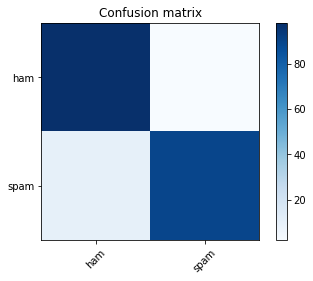

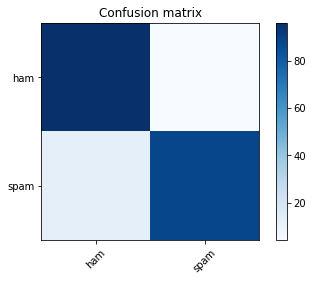

In [50]:
def tokenize_w_punkt(text): # Токенизация с пунктуацией
    return wordpunct_tokenize(text.lower()) 

bow = CountVectorizer(analyzer=tokenize_w_punkt)
print ('Count Vectorizer')
nb_classif(bow)
bow = TfidfVectorizer(analyzer=tokenize_w_punkt)
print('Tf-idf')
nb_classif(bow)

Получается, что лучший результат для байесовского классификатора при CountVectorizer и выделением знаков препинания в отдельные токены 